## Part 1: Pulse Rate Algorithm

### Contents
Fill out this notebook as part of your final project submission.

**You will have to complete both the Code and Project Write-up sections.**
- The [Code](#Code) is where you will write a **pulse rate algorithm** and already includes the starter code.
   - Imports - These are the imports needed for Part 1 of the final project. 
     - [glob](https://docs.python.org/3/library/glob.html)
     - [numpy](https://numpy.org/)
     - [scipy](https://www.scipy.org/)
- The [Project Write-up](#Project-Write-up) to describe why you wrote the algorithm for the specific case.


### Dataset
You will be using the **Troika**[1] dataset to build your algorithm. Find the dataset under `datasets/troika/training_data`. The `README` in that folder will tell you how to interpret the data. The starter code contains a function to help load these files.

1. Zhilin Zhang, Zhouyue Pi, Benyuan Liu, ‘‘TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise,’’IEEE Trans. on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015. Link

-----

### Code

In [10]:
import glob

import numpy as np
import scipy as sp
import scipy.io
import matplotlib.pyplot as plt
import scipy.signal


def LoadTroikaDataset():
    """
    Retrieve the .mat filenames for the troika dataset.

    Review the README in ./datasets/troika/ to understand the organization of the .mat files.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data
        <data_fls> and <ref_fls> are ordered correspondingly, so that ref_fls[5] is the 
            reference data for data_fls[5], etc...
    """
    data_dir = "./datasets/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls

def LoadTroikaDataFile(data_fl):
    """
    Loads and extracts signals from a troika data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for ppg, accx, accy, accz signals.
    """
    data = sp.io.loadmat(data_fl)['sig']
    return data[2:]

def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability. 

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and corresponding 
            reference heart rates.
        confidence_est: a numpy array of confidence estimates for each pulse rate
            error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    #    are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)

    # Find the errors of the best pulse rate estimates
    best_estimates = pr_errors[confidence_est >= percentile90_confidence]

    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))

# Fixed values to avoid magic numbers
fs = 125
secs_in_minute = 60
dist= 0.2

#Added/ Edited functions


def BandpassFilter(signal, pass_band, fs):
    """Bandpass Filter.
    
    Args:
        signal: (np.array) The input signal
        pass_band: (tuple) The pass band. Frequency components outside 
            the two elements in the tuple will be removed.
        fs: (number) The sampling rate of <signal>
        
    Returns:
        (np.array) The filtered signal
    """
    b, a = sp.signal.butter(3, pass_band, btype='bandpass', fs=fs)
    return sp.signal.filtfilt(b, a, signal)


def fourier(signal, fs=fs):
    """
    Do Fourier Calculations.
    
    Args:
        signal: (np.array) The input signal
        fs: (number) The sampling rate of <signal>
        
    Returns:
        ftt: (np.array) The absolute magnitude of the fourier transforms
        freqs: (np.array) The frequencies mapped after performing fourier transformations
    """
    
    
    freqs = np.fft.rfftfreq(len(signal), 1/fs)
    fft = np.abs(np.fft.rfft(signal))
    
    # Filter data
    fft[freqs <= 70/60.0] = 0.0
    fft[freqs >= 190/60.0] = 0.0
    
    return fft, freqs

def calculate_confidence(freqs, fft_mag, bpm_f):
    """
    This function calculates the respective confidence of the heart rate estimates.
    
    Args:
        freqs: (np.array) The frequencies mapped after performing fourier transformations
        ftt_mag: (np.array) The absolute magnitude of the fourier transforms
        bpm_f: (np.array) The heart beat estimates
        
    Returns:
        confidence: (np.array) A numpy array with respective confidence values

    """
    
    window_f = 30/60
    fundamental_freq_window = (freqs > bpm_f - window_f) & (freqs < bpm_f + window_f)
    return np.sum(fft_mag[fundamental_freq_window])/ np.sum(fft_mag)

def determine_hb(ppg, acc, window_length, window_step, fs=fs):
    
    """
    This function determines the estimate heart rate value for each specific window and returns it as a numpy
    array alongside its respective confidence values.
    
    Args:
        ppg: (np.array) The ppg signal
        acc: (np.array) The aggregated acc signal.
        window_length: (int) The size in seconds of each window.
        window_step: (int) The number of seconds that each window should move per iteration
        fs: (number) The sampling rate of ppg and acc.
        
        
    Returns:
        est_bpm_list: (list) A list that containts the estimate heart rate values for each specific window
        confidence_list: (list) A list that containts the confidence values per each estimate heart rate value
        for each specific window.

    """
    
    window_length_fs = window_length*fs
    window_step_fs = window_step*fs
    
    
    est_bpm_list = []
    confidence_list = []
    
    prev_est = 40/60
    
    for i in range(0, len(ppg)-window_length_fs, window_step_fs):
        
        #print("i: "+str(i))
        #for each window...
        ppg_window = ppg[i:i+window_length_fs]
        acc_window = acc[i:i+window_length_fs]
        
        #Get fourier transforms for ppg and acc
        fft_ppg, freqs_ppg = fourier(ppg_window, fs)
        fft_acc, freqs_acc = fourier(acc_window, fs)
        
        #get max 
        freq_max_ppg = freqs_ppg[np.argmax(fft_ppg)]
        freq_max_acc = freqs_acc[np.argmax(fft_acc)]
        
        #ppg
        plt.subplot(4,1,1)
        plt.title("PPG")
        plt.plot(freqs_ppg, fft_ppg)
        plt.xlabel(' ')
        plt.xlim(0,10)
        plt.ylabel('FFT Magnitude')

        #accx
        plt.subplot(4,1,2)
        plt.title("ACC")
        plt.plot(freqs_acc, fft_acc)
        plt.xlabel(' ')
        plt.xlim(0,10)
        plt.ylabel('FFT Magnitude')
        
        k = 1
        
        while np.abs(freq_max_acc-freq_max_ppg) <= dist and k <=2:
            k+=1
            freq_max_ppg = freqs_ppg[np.argsort(fft_ppg, axis=0)[-k]]
            freq_max_acc = freqs_acc[np.argsort(fft_acc, axis=0)[-k]]
        
        est_bpm = freq_max_ppg
        prev_est = est_bpm
        est_bpm_list.append(est_bpm*secs_in_minute)
        
        #Calculate and append confidence
        confidence = calculate_confidence(freqs_ppg, fft_ppg, est_bpm)
        confidence_list.append(confidence)
    
    return est_bpm_list, confidence_list

def get_ref(ref_fl):

    """
    This function loads the reference heart rate values.
    
    Args:
        ref_fl: (np.array) The reference file from where it would extract the values
        
    Returns:
        ref: (np.array) The numpy array containing the values of reference heart beat rates.

    """
    
    ref = sp.io.loadmat(ref_fl)['BPM0'].reshape(-1)
    
    return ref
    
    

def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()
    errs, confs = [], []
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidence)
        # Compute aggregate error metric
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    return AggregateErrorMetric(errs, confs)

def RunPulseRateAlgorithm(data_fl, ref_fl):
    """
    This function loads the signal data and reference heart rate values, creates and estimation of the heart rate
    rate values of signal data, compares it with the reference values to estimate an error rate of the algorithm and
    its confidence.
    
    Args:
        data_fl (np.array) The file containing the signal data.
        ref_fl: (np.array) The reference file from where it would extract the values
        
    Returns:
        errors: (np.array) The numpy array containing the error values.
        conf: (list) A list that containts the confidence values per each estimate heart rate value
        for each specific window.
    """
    
    # Load data using LoadTroikaDataFile
    ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)
    
    
    #Bandpass the data
    pass_band = (40/60., 240/60.)
    ppg = BandpassFilter(ppg, pass_band, fs)
    accx = BandpassFilter(accx, pass_band, fs)
    accy = BandpassFilter(accy, pass_band, fs)
    accz = BandpassFilter(accz, pass_band, fs)
    
    acc = np.sqrt(accx**2 + accy**2 + accz**2)

    # Compute pulse rate estimates and estimation confidence.
    window_length = 8
    window_step = 2
    
    estimates, conf = determine_hb(ppg, acc, window_length, window_step, fs)
    
    bpm = get_ref(ref_fl)

    if len(estimates)==len(bpm):
        errors = np.abs(bpm-estimates)
        
    else:
        errors = np.abs(bpm[:-1]-estimates)
        

    # Return per-estimate mean absolute error and confidence as a 2-tuple of numpy arrays.
    #errors, confidence = np.ones(100), np.ones(100)  # Dummy placeholders. Remove
    return errors, conf

# Test

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


22.897365565116814

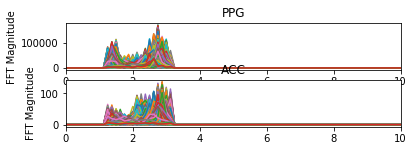

In [11]:
Evaluate()

## EDA

As previous context based on the TROIKA paper and analysis we now that:

* The dataset was recorded from 12 male subjects ages ranging from 18 to 35 with yellow skin.**No additional noise-variance added due to melanin differences between the subjects, that is helpful**
* It used green LED light (wavelength: 515nm).
* All signals were sampled at 125Hz --> **fs=125**
* All participants walked or run, but not in a consistent manner. They all were asked to run at different speeds (increasing it) for certain period of time. **So, we could probably play around by grouping signals based on speeds.** We could probe this theory by taking a look at the Spectogram.
* Additional intended noise was added (participants were asked to use their wristband hand for additional moves like pushing buttons, pulling clothes, etc...) **Take into consideration that as part of noise that might affect the algorithm**

In [15]:
data_fls, ref_fls = LoadTroikaDataset()

In [72]:
ref = sp.io.loadmat(ref_fls[0])['BPM0']
len(ref)

148

In [16]:
ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

In [17]:
len(ppg), len(accx), len(accy), len(accz)

(37937, 37937, 37937, 37937)

In [18]:
fs = 125
ts = np.arange(len(ppg))/fs
length_sec = np.max(ts)
length_min = length_sec/60

print("Total time recorded in seconds: "+str(length_sec))
print("Total time recorded in minutes: "+str(length_min))

Total time recorded in seconds: 303.488
Total time recorded in minutes: 5.05813333333


In [19]:
freqs = np.fft.rfftfreq(len(ppg), 1/fs)
fft = np.abs(np.fft.rfft(ppg))
len(freqs), len(fft)

(18969, 18969)

In [2]:
# If we want to combine all our data into one dataset

def combine_one_dataset(data_fls):
    """
    Combine all signals into one dataset.

    Takes all the signals, calls LoadTroikaDataFile, and combines the ppg, and accelerometers of all signals.

    Returns:
        ppg, accx, accy, accz of all signals.
    """
    ppg_list = []
    accx_list = []
    accy_list = []
    accz_list = []
    for troika in data_fls:
        ppg, accx, accy, accz = LoadTroikaDataFile(troika)
        for i in range(len(ppg)):
            ppg_list.append(ppg[i])
            accx_list.append(accx[i])
            accy_list.append(accy[i])
            accz_list.append(accz[i])


    ppg = np.array(ppg_list)
    accx = np.array(accx_list)
    accy = np.array(accy_list)
    accz = np.array(accz_list)
    
    return ppg, accx, accy, accz
    

In [20]:
def plot_freqs(ppg, accx, accy, accz, fs):
    
    # Get FFT of PPG
    freqs_ppg = np.fft.rfftfreq(len(ppg), 1/fs)
    fft_ppg = np.abs(np.fft.rfft(ppg))
    
    # Get FFT of PPG
    freqs_accx = np.fft.rfftfreq(len(accx), 1/fs)
    fft_accx = np.abs(np.fft.rfft(accx))
    
    # Get FFT of accy
    freqs_accy = np.fft.rfftfreq(len(accy), 1/fs)
    fft_accy = np.abs(np.fft.rfft(accy))
    
    # Get FFT of accz
    freqs_accz = np.fft.rfftfreq(len(accz), 1/fs)
    fft_accz = np.abs(np.fft.rfft(accz))
    
    #Plot
    plt.figure(figsize=(16, 12))
    
    #ppg
    plt.subplot(4,1,1)
    plt.title("PPG")
    plt.plot(freqs_ppg, fft_ppg)
    plt.xlabel(' ')
    plt.xlim(0,10)
    plt.ylabel('FFT Magnitude')
    
    #accx
    plt.subplot(4,1,2)
    plt.title("ACCX")
    plt.plot(freqs_accx, fft_accx)
    plt.xlabel(' ')
    plt.xlim(0,10)
    plt.ylabel('FFT Magnitude')
    
    #ppg
    plt.subplot(4,1,3)
    plt.title("ACCY")
    plt.plot(freqs_accy, fft_accy)
    plt.xlim(0,10)
    plt.xlabel('. ')
    plt.ylabel('FFT Magnitude')
    
    #ppg
    plt.subplot(4,1,4)
    plt.title("ACCZ")
    plt.plot(freqs_accz, fft_accz)
    plt.xlabel('Freqs (Hz)')
    plt.ylabel('FFT Magnitude')
    plt.xlim(0,10)
    
    plt.tight_layout()

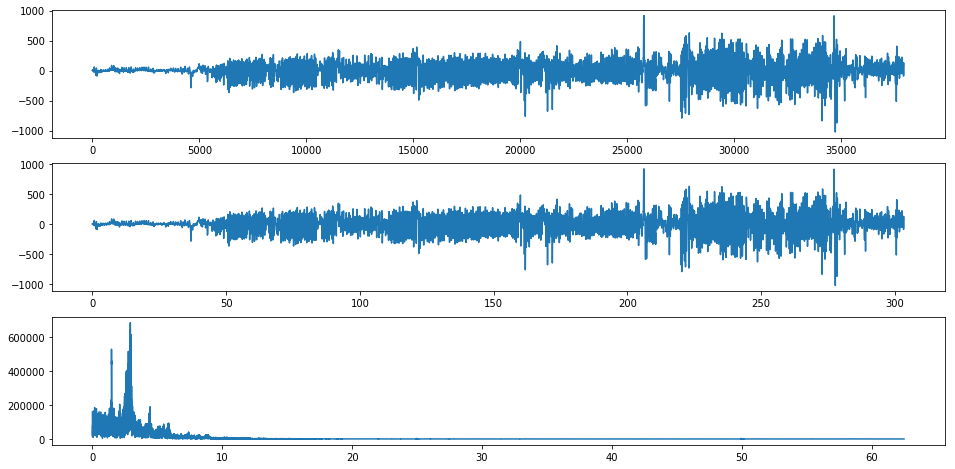

In [21]:
# Plot the ppg curve


plt.figure(figsize=(16,8))
plt.subplot(3,1,1)
plt.plot(ppg)
#plt.xlim(50000,60000)

plt.subplot(3,1,2)
plt.plot(ts, ppg)

plt.subplot(3,1,3)
plt.plot(freqs, fft)


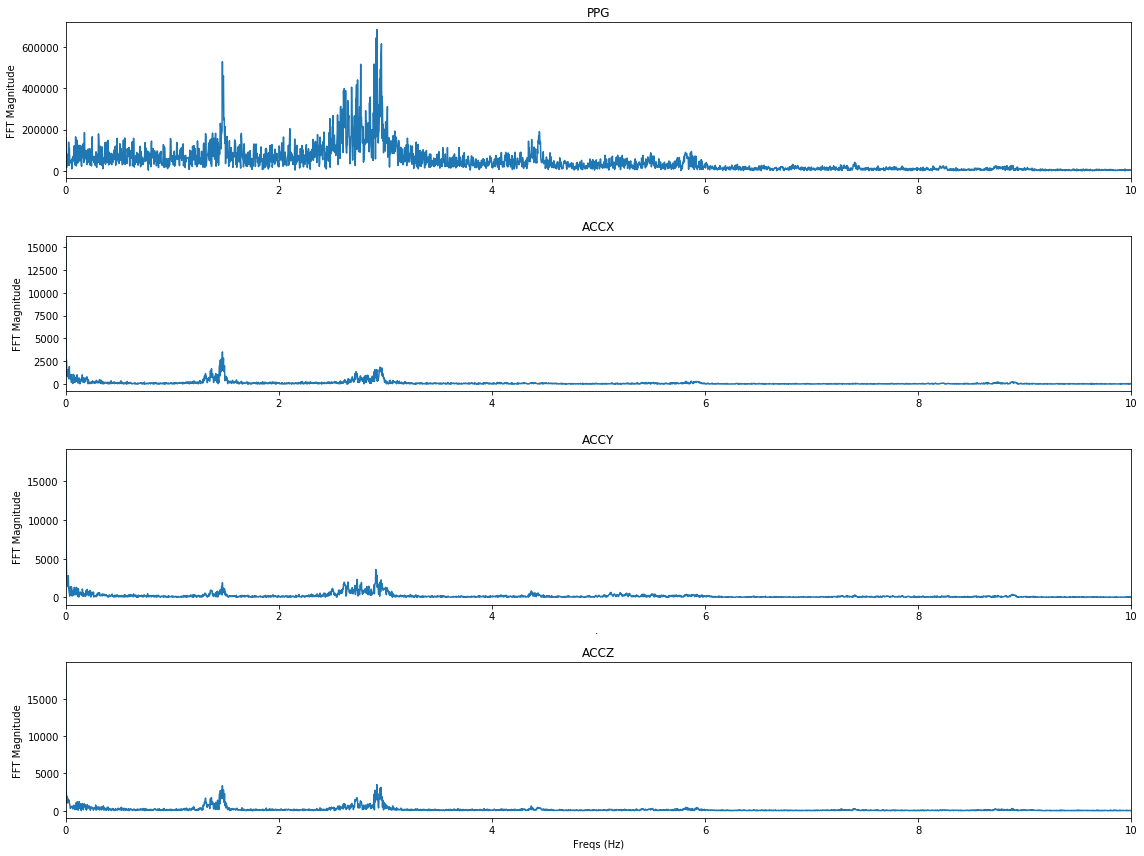

In [22]:
plot_freqs(ppg,accx,accy,accz,fs)

(0, 10)

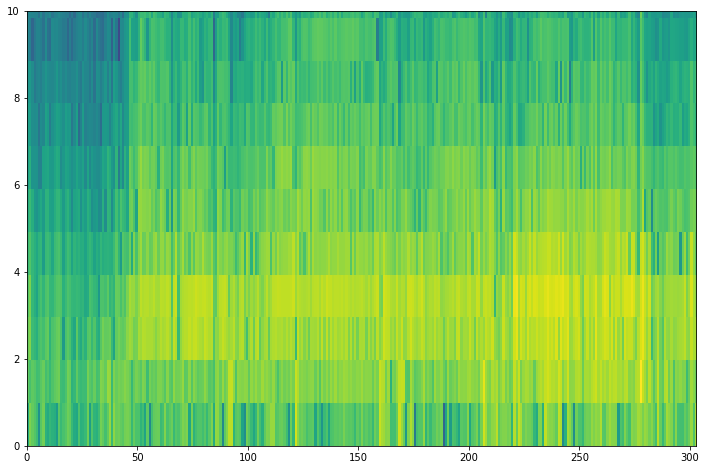

In [23]:
plt.figure(figsize=(12,8))
spec, freqs, _,_ = plt.specgram(ppg, Fs=fs, NFFT=fs*1, noverlap=0)
plt.ylim(0,10)

-----
### Project Write-up

Answer the following prompts to demonstrate understanding of the algorithm you wrote for this specific context.

> - **Code Description** - Include details so someone unfamiliar with your project will know how to run your code and use your algorithm. 
> - **Data Description** - Describe the dataset that was used to train and test the algorithm. Include its short-comings and what data would be required to build a more complete dataset.
> - **Algorithhm Description** will include the following:
>   - how the algorithm works
>   - the specific aspects of the physiology that it takes advantage of
>   - a describtion of the algorithm outputs
>   - caveats on algorithm outputs 
>   - common failure modes
> - **Algorithm Performance** - Detail how performance was computed (eg. using cross-validation or train-test split) and what metrics were optimized for. Include error metrics that would be relevant to users of your algorithm. Caveat your performance numbers by acknowledging how generalizable they may or may not be on different datasets.

Your write-up goes here...

-----
### Next Steps
You will now go to **Test Your Algorithm** to apply a unit test to confirm that your algorithm met the success criteria. 

### Write-up

**Code Description**

Import required libraries:

1) glob

2) numpy= "==1.17.4"

3) scipy = "==1.3.2"

    4) scipy.io
    
    5) scipy.signal
    
6) matplotlib = "==3.1.1"

Parameters

These are important parameters to take into consideration:

* fs. Its set to 125. DO NOT CHANGE THIS VALUE, since that was sampling rate used to collect this dataset.
* pass_band (40-240). Can change it but you probably don't want to since it assumes a 'normal' bandwith for human heart rate.
* dist is set to 0.2. This distance between peaks at signals can be changed. 0.2 default value but feel free to experiment.
* window_length = 8. Default to 8 but feel free to change the length of analyzed window. Be wary of too large or too small windows.
* window_step = 2; default to 2 since exercised established a 2 seconds step. It is possible to change this value if not specified


Calling the Evaluation() function will run the entire program. The program would call some .mat files that contain PPG and Accelerometer data. An algorithm will read these signals, predict the heart-beat and compare it to the reference dataset with a error and confidence value.

**Data Description**
* The dataset is collected via a PPG sensor and a 3 channel accelerometer. The PPG sensor beams 'green' light into the wrist. Red-cells in the blood stream absorbe that light. The amount of blood cells present at a certain point in time determines how much light is reflected back to the sensors. The good news is that this process happens periodically due to the natural heart beat. The difference in amount of light reflected present a 
* The dataset was recorded from 11 male subjects (1 person recorded 2 sessions) ages ranging from 18 to 35 with yellow skin.**No additional noise-variance added due to melanin differences between the subjects, that is helpful**
* It used green LED light (wavelength: 515nm).
* All signals were sampled at 125Hz --> **fs=125**
* All participants walked or run, but not in a consistent manner. They all were asked to run at different speeds (increasing it) for certain period of time.
* Additional intended noise was added (participants were asked to use their wristband hand for additional moves like pushing buttons, pulling clothes, etc...) **Take into consideration that as part of noise that might affect the algorithm**

    **Short-comings:** 
    * This dataset might fail to produce optimal results when taking signals that have been heavily affected by other type of motion noise. Since this dataset was only trained using run and walking data, a cycling/swimming signal might have  a different response.
    * Other noise factors might also apply. For instance, if tried on signal data takem from a participant with darkers skin color. Diversity is important and collecting this type of data would be really helpful to perfect the algorithm. Also, this applies to age and sex features.

**Algorithm Description**
* Evalute() would call the function LoadTroikaDataset() which would load the data from the .mat files
* For each file the RunPulseRateAlgorithm(...) will be called.
* RunPulseRate would:
    * Apply a bandpass filter to the ppg and acc data (40-240bpm)
    * acc[n] data is aggregated
    * Window parameters are established and passed to determine_hb() function
* determine_hb():
    * loops through each window calculating the Fourier transform values for ppg and acc data and;
    * extracts the maximum (peak) value of frequency magnitude per window for each one. It takes into consideration proximity between both values (ppg-acc) to discard potential noise.
    * Based on these max. values calculations both the heart rate and the confidence values are computed, the latter by calling the calculate_confidence() function.
    * The function returns the estimate heart rate and confidence values
* RunPulseRate will compute the error rates.
* Evaluate() will finish up by evaluating the algorithm.

**Algorithm Performance:**

* The performance was calculated by calculating the mean absolute error between the heart rate estimation computed by our algorithm and the reference heart rate values. Such ground truth came from ECG sensors at 90% availability. Put another way, 90% of the best estimates according to the algorithm's confidence scores.

* By incorporating confidence scores we are able to produce a higher number of better estimates since we establish a form of thresholding effect in which the consumer of the algorithm can decide to consume the estimates. For each window analyzed a confidence score is computed by identifying the main frequency and evaluating the magnitude of the the frequencies close to it. A great concentration produces a better confidence estimate. 

* It is important to consider that this algorithm was modeled with running, jogging, and running in mind as activities occurring while measuring and the performance of this algorithm will probably decrease if the data to which it is applied is from other activity. Not only that, other demographic factors and medical conditions could affect the distribution of data and the performance of this algorithm.

* To improve performance, deeper techinques such as a machine learning approach could help a lot, thought, at the likely expense in generalization. Also more test participantes performing a wide range of acitivities and greater diversity in the participants (not only yellow young male... need some browner women in the room please.) could be really beneficial.